In [2]:
# import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import math
from scipy.spatial import distance
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
# import mnist_reader
mnist = input_data.read_data_sets('data/fashion')



train_images = np.asarray(mnist.train.images)
train_labels = np.asarray(mnist.train.labels)
test_images = np.asarray(mnist.test.images)
test_labels = np.asarray(mnist.test.labels)

print("Done Loading images as train and test")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/fashion\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/fashion\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
Done Loading images as train and test


In [3]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(55000, 784)
(55000,)
(10000, 784)
(10000,)


In [4]:
data_X = list(train_images) + list(test_images)
data_Y = list(train_labels) + list(test_labels)
print(len(data_X))
print(len(data_Y))
train_data = []
for i in range(len(train_images)):
    train_data.append([data_Y[i], data_X[i]])
print("Done creating train data")

65000
65000
Done creating train data


In [5]:
training = train_data
print("Done creating training")

Done creating training


In [6]:
def check_twos():
    twos = []
    frequency = {x:0 for x in range(10)}

    for (label,digit) in validation:
        inferred_label = classify_digit(digit, labelled_centroids)
        if inferred_label==2:
            twos.append(digit)
            frequency[label] +=1
            
    print(frequency)

In [7]:
import matplotlib.pyplot as plt
def display_digit(digit, labeled = True, title = ""):
    if labeled:
        digit = digit[1]
    image = digit.reshape(28,28)
    plt.figure()
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if title != "":
        plt.title("Inferred label: " + str(title))
    plt.show()
        
        
def show_image(centroids):

    for i in range(len(centroids)):
        image = centroids[i]
        fig = plt.imshow(image.reshape(28,28))
        fig.set_cmap('gray_r')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False) 
        
        plt.show()

In [8]:
import random
def init_centroids(labelled_data,k):
    return map(lambda x: x[1], random.sample(labelled_data,k))
k = 10

In [9]:
def sum_cluster(labelled_cluster):
    sum_ = labelled_cluster[0][1].copy()
    for (label,vector) in labelled_cluster[1:]:
        sum_ += vector
    return sum_

def mean_cluster(labelled_cluster):
    sum_of_points = sum_cluster(labelled_cluster)
    mean_of_points = sum_of_points * (1.0 / len(labelled_cluster))
    return mean_of_points

In [10]:
def form_clusters(labelled_data, unlabelled_centroids):
    
    centroids_indices = range(len(unlabelled_centroids))
    clusters = {c: [] for c in centroids_indices}
    for (label,Xi) in labelled_data:
        smallest_distance = float("inf")
        for cj_index in centroids_indices:
            cj = unlabelled_centroids[cj_index]
            distance = np.linalg.norm(Xi - cj)
            if distance < smallest_distance:
                closest_centroid_index = cj_index
                smallest_distance = distance
        
        clusters[closest_centroid_index].append((label,Xi))
    return clusters.values()

In [11]:
def move_centroids(labelled_clusters):
    new_centroids = []
    for cluster in labelled_clusters:
        new_centroids.append(mean_cluster(cluster))
    return new_centroids

In [30]:
def repeat_until_convergence(labelled_data, labelled_clusters, unlabelled_centroids):
    previous_max_difference = 100000
    iter = 0
    max_iter = 20
    while iter < 10:
        iter += 1
        print ("Updating centroids for iteration: ", iter)
        unlabelled_old_centroids = unlabelled_centroids
        unlabelled_centroids = move_centroids(labelled_clusters)
        labelled_clusters = form_clusters(labelled_data, unlabelled_centroids)
        # keep old_clusters and clusters so we can get the maximum difference
        # between centroid positions every time.
        differences = map(lambda a, b: np.linalg.norm(a-b),unlabelled_old_centroids,unlabelled_centroids)
        max_difference = max(differences)
        print("max difference: ", max_difference)
        print("-----------------------------------")
        difference_change = abs((max_difference-previous_max_difference)/np.mean([previous_max_difference,max_difference])) * 100
        previous_max_difference = max_difference
        if np.isnan(difference_change):
            break
    return labelled_clusters, unlabelled_centroids

In [13]:
def cluster(labelled_data, k):
    centroids = list(init_centroids(labelled_data, k))
    clusters = form_clusters(labelled_data, centroids)
    final_clusters, final_centroids = repeat_until_convergence(labelled_data, clusters, centroids)
    print ("Exiting cluster function")
    return final_clusters, final_centroids

In [14]:
import itertools
import operator

def most_common(L):
    SL = sorted((x, i) for i, x in enumerate(L))
    groups = itertools.groupby(SL, key=operator.itemgetter(0))
    def _auxfun(g):
        item, iterable = g
        count = 0
        min_index = len(L)
        for _, where in iterable:
            count += 1
            min_index = min(min_index, where)
        return count, -min_index
    return max(groups, key=_auxfun)[0]

In [15]:
def assign_labels_to_centroids(clusters, centroids):
    labelled_centroids = []
    clusters = list(clusters)
    for i in range(len(clusters)):
        labels = []
        for k in clusters[i]:
            labels.append(k[0])
        common = most_common(labels)
        centroid = (common, centroids[i])
        labelled_centroids.append(centroid)
    return labelled_centroids

In [16]:
def classify_digit(digit, labelled_centroids):
    mindistance = float("inf")
    for (label, centroid) in labelled_centroids:
        distance = np.linalg.norm(centroid - digit)
        if distance < mindistance:
            mindistance = distance
            closest_centroid_label = label
    return closest_centroid_label

In [22]:
def get_dict(cluster):
    d = dict()
    for j in range(len(cluster)):
        label = cluster[j][0]
        if label in d:
            d[label] += 1
        else:
            d[label] = 1
    return d

In [23]:
def get_dict_difference(d1, d2):
    difference = 0
    for i,j in zip(d1, d2):
        for a,b in zip(i,j):
            difference += (abs(a-b))
    print ("Diff: ", difference/2)
    return difference/2

In [24]:
import math
def calculate_gini_index(d,size):
    val = 0.0
    for label in d:
        val += math.pow((d[label]/size), 2)
    return 1 - val    

In [25]:
def get_gini_index(clusters):
    size = []
    gini_index = []
    for cluster in clusters:
        d = get_dict(cluster)
        l = len(cluster)
        size.append(l)
        gini_index.append(calculate_gini_index(d,l))
    g_index = 0
    for i in range(len(clusters)):
        g_index += gini_index[i]*size[i]
    return g_index/len(training)

In [26]:
def get_purity(clusters):
    size = []
    purity = []
    for cluster in clusters:
        d = get_dict(cluster)
        l = len(cluster)
        size.append(l)
        purity.append(max(list(d.values())))

    return sum(purity)/len(training)

In [18]:
def get_error_rate(labelled_digits,labelled_centroids):
    classified_incorrect = 0
    for (label,digit) in labelled_digits:
        classified_label = classify_digit(digit, labelled_centroids)
        if classified_label != label:
            classified_incorrect +=1
    error_rate = classified_incorrect / float(len(train_data))
    return error_rate

In [28]:
def kmeans(k):
    clusters, centroids = cluster(training, k)
    g = get_gini_index(clusters)
#     print("Calculating purity")
    purity = get_purity(clusters)
    print(purity)
    labelled_centroids = assign_labels_to_centroids(clusters, centroids)
    purity = get_purity(clusters)
    error_rate = get_error_rate(training, labelled_centroids)
    return error_rate, purity, g 

Performing KMeans for k = 5
Updating centroids for iteration:  1
max difference:  6.01567
-----------------------------------
Updating centroids for iteration:  2
max difference:  1.04564
-----------------------------------
Updating centroids for iteration:  3
max difference:  0.944941
-----------------------------------
Updating centroids for iteration:  4
max difference:  0.60835
-----------------------------------
Updating centroids for iteration:  5
max difference:  0.437923
-----------------------------------
Updating centroids for iteration:  6
max difference:  0.376448
-----------------------------------
Updating centroids for iteration:  7
max difference:  0.376235
-----------------------------------
Updating centroids for iteration:  8
max difference:  0.403565
-----------------------------------
Updating centroids for iteration:  9
max difference:  0.472011
-----------------------------------
Updating centroids for iteration:  10
max difference:  0.58054
---------------------

max difference:  0.240898
-----------------------------------
Exiting cluster function
Performing KMeans for k = 13
Updating centroids for iteration:  1
max difference:  5.86467
-----------------------------------
Updating centroids for iteration:  2
max difference:  1.3811
-----------------------------------
Updating centroids for iteration:  3
max difference:  1.00821
-----------------------------------
Updating centroids for iteration:  4
max difference:  1.04475
-----------------------------------
Updating centroids for iteration:  5
max difference:  1.09916
-----------------------------------
Updating centroids for iteration:  6
max difference:  0.799279
-----------------------------------
Updating centroids for iteration:  7
max difference:  0.437858
-----------------------------------
Updating centroids for iteration:  8
max difference:  0.334358
-----------------------------------
Updating centroids for iteration:  9
max difference:  0.313162
-----------------------------------

max difference:  0.584126
-----------------------------------
Updating centroids for iteration:  10
max difference:  0.407268
-----------------------------------
Exiting cluster function
Performing KMeans for k = 21
Updating centroids for iteration:  1
max difference:  6.57765
-----------------------------------
Updating centroids for iteration:  2
max difference:  1.75205
-----------------------------------
Updating centroids for iteration:  3
max difference:  1.45624
-----------------------------------
Updating centroids for iteration:  4
max difference:  0.971284
-----------------------------------
Updating centroids for iteration:  5
max difference:  0.798252
-----------------------------------
Updating centroids for iteration:  6
max difference:  0.692107
-----------------------------------
Updating centroids for iteration:  7
max difference:  0.489299
-----------------------------------
Updating centroids for iteration:  8
max difference:  0.601074
-------------------------------

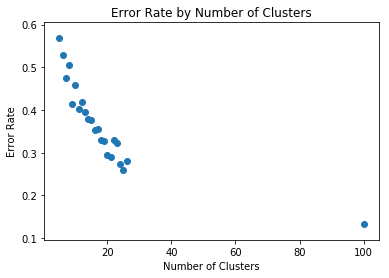

In [47]:
all_k = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,100]
error_rates = []
purity_rates = []
gini = []
for k in all_k:
    print("Performing KMeans for k =", k)
    error, purity, g = kmeans(k)
    error_rates.append(error)
    purity_rates.append(purity)
    gini.append(g)
print(error_rates)
print(purity_rates)

x_axis = all_k
y_axis = error_rates
plt.figure()
plt.title("Error Rate by Number of Clusters")
plt.scatter(x_axis, y_axis)
plt.xlabel("Number of Clusters")
plt.ylabel("Error Rate")
plt.show()

In [31]:
kmeans(10)

Updating centroids for iteration:  1
max difference:  6.06383
-----------------------------------
Updating centroids for iteration:  2
max difference:  1.60957
-----------------------------------
Updating centroids for iteration:  3
max difference:  0.839471
-----------------------------------
Updating centroids for iteration:  4
max difference:  0.797852
-----------------------------------
Updating centroids for iteration:  5
max difference:  0.732258
-----------------------------------
Updating centroids for iteration:  6
max difference:  0.52635
-----------------------------------
Updating centroids for iteration:  7
max difference:  0.3746
-----------------------------------
Updating centroids for iteration:  8
max difference:  0.262073
-----------------------------------
Updating centroids for iteration:  9
max difference:  0.24458
-----------------------------------
Updating centroids for iteration:  10
max difference:  0.30145
-----------------------------------
Exiting cluster 

(0.4102545454545454, 0.5897454545454546, 0.5718581674275715)